In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#dataset https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format
data = pd.read_csv('.//Data//A_Z Handwritten Data.csv').astype('float32')

In [3]:
data.rename(columns={'0':'label'}, inplace=True)

In [4]:
X_full = data.drop('label',axis = 1)
y_full = data['label']

2.0


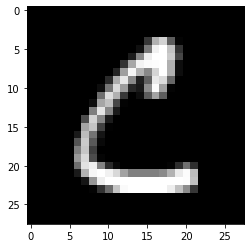

In [5]:
print(y_full[30000])
plt.imshow(X_full.iloc[30000].values.reshape(28,28), cmap='gray')
plt.show()

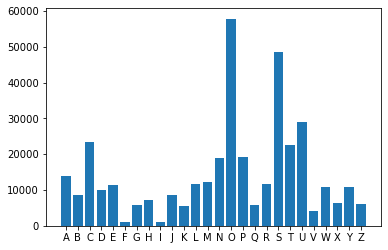

In [6]:
import string

letter_count = data.groupby('label').size()
plt.bar(list(string.ascii_uppercase), letter_count)
plt.show()

In [7]:
X_full = X_full / 255.0

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(223470, 784)
(74490, 784)
(74490, 784)


In [10]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.to_numpy().reshape(X_test.shape[0], 28, 28, 1).astype('float32')
X_valid = X_valid.to_numpy().reshape(X_test.shape[0], 28, 28, 1).astype('float32')

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_valid = keras.utils.to_categorical(y_valid)

In [11]:
X_train.shape[1:]

(28, 28, 1)

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(y_full.unique().size, activation='softmax')
])

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
y_train.shape

(223470, 26)

In [17]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                   validation_data=(X_valid, y_valid),
                   callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
6984/6984 [==============================] - 20s 3ms/step - loss: 0.2219 - accuracy: 0.9363 - val_loss: 0.1153 - val_accuracy: 0.9656
Epoch 2/100
6984/6984 [==============================] - 19s 3ms/step - loss: 0.0977 - accuracy: 0.9711 - val_loss: 0.0926 - val_accuracy: 0.9734
Epoch 3/100
6984/6984 [==============================] - 19s 3ms/step - loss: 0.0725 - accuracy: 0.9783 - val_loss: 0.0839 - val_accuracy: 0.9759
Epoch 4/100
6984/6984 [==============================] - 20s 3ms/step - loss: 0.0583 - accuracy: 0.9820 - val_loss: 0.0771 - val_accuracy: 0.9794
Epoch 5/100
6984/6984 [==============================] - 19s 3ms/step - loss: 0.0487 - accuracy: 0.9848 - val_loss: 0.0823 - val_accuracy: 0.9788
Epoch 6/100
6984/6984 [==============================] - 20s 3ms/step - loss: 0.0434 - accuracy: 0.9865 - val_loss: 0.0854 - val_accuracy: 0.9801
Epoch 7/100
6984/6984 [==============================] - 20s 3ms/step - loss: 0.0376 - accuracy: 0.9884 - val_loss: 0.0953 -

In [18]:
model.evaluate(X_test, y_test)

2328/2328 [==============================] - 4s 2ms/step - loss: 0.1129 - accuracy: 0.9847


[0.11294176429510117, 0.9847362041473389]

In [19]:
model.save('.//Models//acc98')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .//Models//acc98/assets
